In [98]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve, f1_score, recall_score, precision_score, precision_recall_curve, accuracy_score
from myfunctions import prediction_matrices

import warnings
warnings.filterwarnings("ignore")

First, we load the final DataFrame from notebook 4.

In [48]:
df_train = pd.read_pickle('./data/df_train.pkl')
df_test = pd.read_pickle('./data/df_test.pkl')

# Assign Target and Features

In [49]:
X_train = df_train.drop("churn_risk_score", axis = 1)
y_train = df_train["churn_risk_score"]

X_test = df_test.drop("churn_risk_score", axis = 1)
y_test = df_test["churn_risk_score"]

Convert target into integer for compatibility of models

In [50]:
#df_train = df_train.astype(float)
y_train = y_train.astype(int)

y_test = y_test.astype(int)

# Logistic Regression

In [51]:
# Instatiate model and fit on train data

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

## Prediction scores and matrices

Report on train set : 
               precision    recall  f1-score   support

           0       0.85      0.82      0.83     11105
           1       0.85      0.87      0.86     13215

    accuracy                           0.85     24320
   macro avg       0.85      0.85      0.85     24320
weighted avg       0.85      0.85      0.85     24320

--------------------------------------------------------------------------------
Accuracy on test set: 0.85
ROC on test set: 0.95
Report on test set : 
               precision    recall  f1-score   support

           0       0.85      0.82      0.84      4860
           1       0.85      0.88      0.86      5536

    accuracy                           0.85     10396
   macro avg       0.85      0.85      0.85     10396
weighted avg       0.85      0.85      0.85     10396



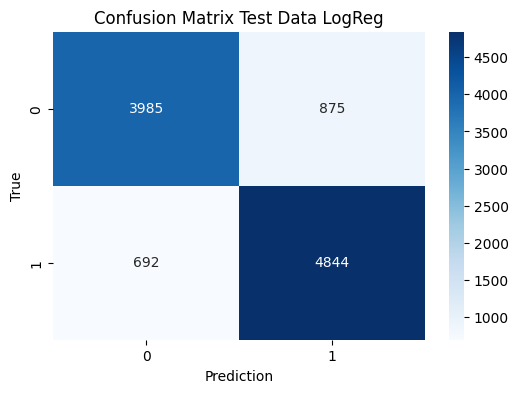

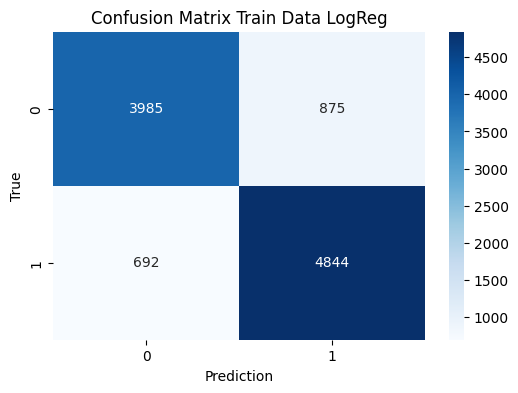

In [52]:
prediction_matrices(model = logreg, X_test = X_test, X_train= X_train, y_test= y_test, y_train = y_train, model_name= "LogReg")

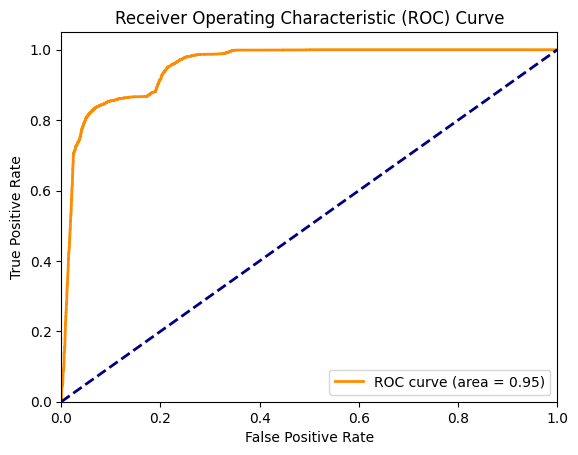

In [53]:
# ROC Curve
y_pred_roc = logreg.predict_proba(X_test)[:, 1] # Probability of positive class

fpr, tpr, thresholds = roc_curve(y_test, y_pred_roc)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



## Score evaluation

All scores for prediction on train and test data are in a very similar range indicating that there is no obvious overfitting. Most scores are usually around 85%. Moreover, similar values for precision and recall indicate a balanced prediction accuracy for both predictable classes. 

The ROC is a graphical representation of the performance of a classification model across different thresholds. Taking a look on the curve, we noticed a plateau for TPR (approx. 0.85) for a FPR range from 0.1 - 0.2 and a 'jump' towards 1 beyond 0.2. This indicates a steep improvement of the model performance above a FPR of 0.2. 

What is next? Since the TPR represents TPR and FPR for different thresholds, we can change the threshold to tune scores like accuracy, precision, recall (and F1) according to the stakeholder´s needs. If we just want to maximize accuracy (and since this is a quite balanced dataset it is not a bad idea) we could minimize FPR while maximizing TPR. Graphically, this point is at a FPR of around 0.25 and a TPR >0.95. But what is the threshold for that.

- find new threshold, min(FPR), max(TPR)
- Graphik um Threshold zu verschieben

We achieve a higher score for ROC AUC with 95%. Looking on the score, we can observe a "jump" at 

However, there 

- Imbalance

- overfitting underfitting
- scores accuracy, precision, recall, roc

Report on train set : 
               precision    recall  f1-score   support

           0       0.85      0.82      0.83     11105
           1       0.85      0.87      0.86     13215

    accuracy                           0.85     24320
   macro avg       0.85      0.85      0.85     24320
weighted avg       0.85      0.85      0.85     24320

--------------------------------------------------------------------------------
Accuracy on test set: 0.85
ROC on test set: 0.95
Report on test set : 
               precision    recall  f1-score   support

           0       0.85      0.82      0.84      4860
           1       0.85      0.88      0.86      5536

    accuracy                           0.85     10396
   macro avg       0.85      0.85      0.85     10396
weighted avg       0.85      0.85      0.85     10396

ROC curve results in very good scores

In [78]:
# acknowledgements go to https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

# calculate the geometric mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# Youden’s J statistic
# basically max TPR for min FPR
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.674672


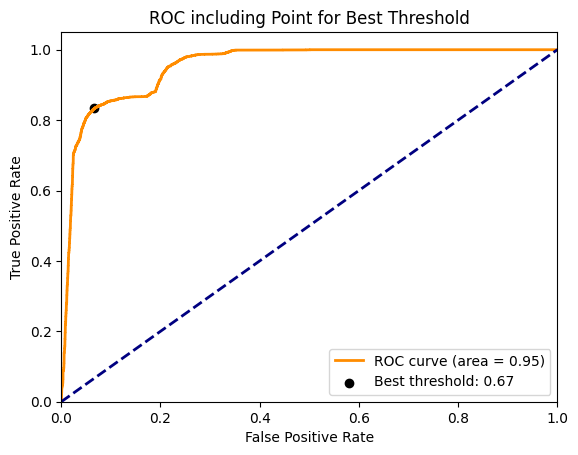

In [79]:
# Plot ROC curve including best threshold for max g-mean
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label=f'Best threshold: {best_thresh.round(2)}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC including Point for Best Threshold')
plt.legend(loc="lower right")
plt.show()


Unlike our first estimate, the best point is below a FPR of 0.2. Mathematically, it seems to be more efficient to allow a lower TPR for a smaller FPR.

Not lets tune precision and recall dependent on the set threshold:

In [80]:
from sklearn.metrics import 

Best Threshold=0.296057, F-Score=0.891


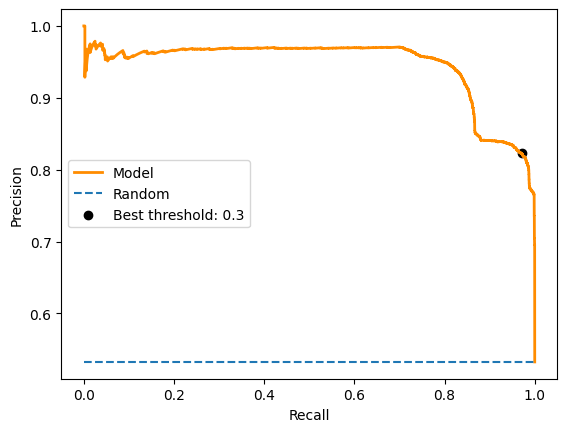

In [91]:
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_roc)

# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)

plt.plot(recall, precision, color='darkorange', lw=2, label='Model')
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='Random')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label=f'Best threshold: {thresholds[ix].round(2)}')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [101]:
# define thresholds
thresholds = np.arange(0, 1, 0.01)

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
 return (pos_probs >= threshold).astype('int')

# evaluate each threshold
f1scores = [f1_score(y_test, to_labels(y_pred_roc, t)) for t in thresholds]
recall = [recall_score(y_test, to_labels(y_pred_roc, t)) for t in thresholds]
precision = [precision_score(y_test, to_labels(y_pred_roc, t)) for t in thresholds]
accuracy = [accuracy_score(y_test, to_labels(y_pred_roc, t)) for t in thresholds]

# get best threshold
ix = np.argmax(f1scores)
print("Scores for maximized F1_score:")
print("________________________________")
print('Threshold=%.3f, F1-Score=%.3f' % (thresholds[ix], f1scores[ix]))
print('Precision=%.3f, Recall=%.3f, Accuracy = %.3f' % (precision[ix], recall[ix], accuracy[ix]))

Scores for maximized F1_score:
________________________________
Threshold=0.290, F1-Score=0.890
Precision=0.818, Recall=0.978, Accuracy = 0.872


## Save Model

In [54]:
# Save model
with open('./model/model_logreg.pkl', 'wb') as file:
    pickle.dump(logreg, file)

## Feature Importance for one-hot encoded Features

Feature Importance:
                                        Feature  Importance
33               feedback_User Friendly Website    4.478648
30               feedback_Quality Customer Care    4.338921
31                    feedback_Reasonable Price    4.334934
29            feedback_Products always in Stock    4.315239
34                          membership_category    1.542112
4                              points_in_wallet    0.484218
8                                gender_Unknown    0.267394
27                feedback_Poor Product Quality    0.186488
26               feedback_Poor Customer Service    0.078349
16                     medium_of_operation_Both    0.077951
19                  internet_option_Mobile_Data    0.060411
11                      region_category_Village    0.060207
25                    complaint_status_Unsolved    0.053480
22              complaint_status_Not Applicable    0.052019
13                  joined_through_referral_Yes    0.041567
20                  

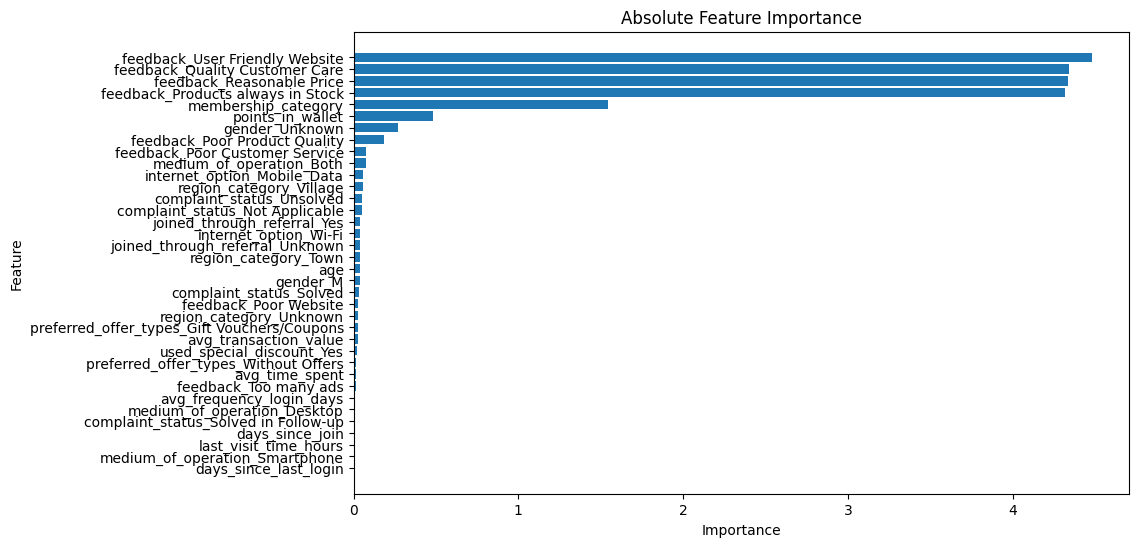

In [55]:
# Read coefficents of logistic regression which contain the feature importance of this model
coefficients = logreg.coef_[0]
# Create list of absolute feature importance
feature_importance_abs = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(coefficients)
})
# Sort absolut feature importance in descending order
feature_importance_abs = feature_importance_abs.sort_values(by='Importance', ascending=False)
print("Feature Importance:")
print(feature_importance_abs)


plt.figure(figsize=(10, 6))
plt.barh(feature_importance_abs['Feature'], feature_importance_abs['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Absolute Feature Importance')
plt.gca().invert_yaxis()  # invert axis for most importance feature at top
plt.show()

We used the absolute value of the optimized coefficients to get an estimate of the importance of each one-hot encoded feature. We decided to show the absolute feature importance. However, some values are originally negative and reflect a tendency towards prediction churn 0 or churn 1. Interestingly according to this analysis, especially feedback seems to have a very high importance for the decision of a customer to churn. Other important features seem to be the membership_category and points_in_wallet.

**Limitation**
To avoid multicolinearity, we decided to use "drop_first" to drop one column for each one-hot encoded original feature. Therefore, the list of one-hot encoded features does not represent all possible feature values. However, their values may include an implicit importance of the dropped one-hot encoded feature. Especially feature importance of categorical features with very few values might be distorted by this.

Moreover, the feature importance shown here is independent on the relative proportion for the whole population. For instance, gender_Unknown gets a relatively high feature importance but only represents a population far below 1%.

## Summarizing feature importance for the original feature

To get a better understanding for the overall importance of a feature, we need to summarize all one-hot encoded features to get an estimate of the importance of the original feature. In fact, the one-hot encoded features actually represent the values of the original feature and not the original variable itself. Furthermore, the one-hot encoded features belonging to the same original feature may be positive or negative. If just using 'sum' for summarizing, we might lose information since those features may cancel each other out. 

Therefore, we
1. convert all importances to absolute values;
2. trunc the names of the one-hot encoded feature names to the original feature name;
3. use the original feature name to group the importance as sum to get an estimate of the overall importance

**Limitations**
We stress that this approach just gives an estimate of the overall importance for a specific feature. For instance, for some one-hot encoded features (and by that the feature values) might get a high importance but only represent a small portion of the whole population. Alternatives might include a weighted sum where each value would be weighted according to their relative proportion in the whole population.

In [56]:
#get the original variable names
original_features = pd.read_pickle('./data/df_train_KNN.pkl')
original_features.drop('churn_risk_score', axis=1, inplace=True)
original_features = original_features.columns
print(original_features) 

Index(['age', 'gender', 'region_category', 'membership_category',
       'joined_through_referral', 'preferred_offer_types',
       'medium_of_operation', 'internet_option', 'days_since_last_login',
       'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days',
       'points_in_wallet', 'used_special_discount', 'complaint_status',
       'feedback', 'last_visit_time_hours', 'days_since_join'],
      dtype='object')


In [57]:
#overwrite 
for feature in feature_importance["Feature"]:
   for original in original_features:
      if feature.startswith(original):
         feature_importance["Feature"][feature_importance["Feature"] == feature]= original

feature_importance

,Feature,Importance
27,feedback,0.186488
26,feedback,0.078349
19,internet_option,0.060411
13,joined_through_referral,0.041567
12,joined_through_referral,0.040434
0,age,0.037634
23,complaint_status,0.031424
28,feedback,0.028097
10,region_category,0.026216
2,avg_transaction_value,0.025432


In [58]:
#get absolute values for importance
feature_importance["Importance"] = feature_importance["Importance"].apply(lambda x: np.abs(x))

#sum importance grouped by each original feature
original_feature_importances = feature_importance.groupby("Feature")\
        .sum()\
        .sort_values(by = "Importance", ascending= False)\
        .reset_index()

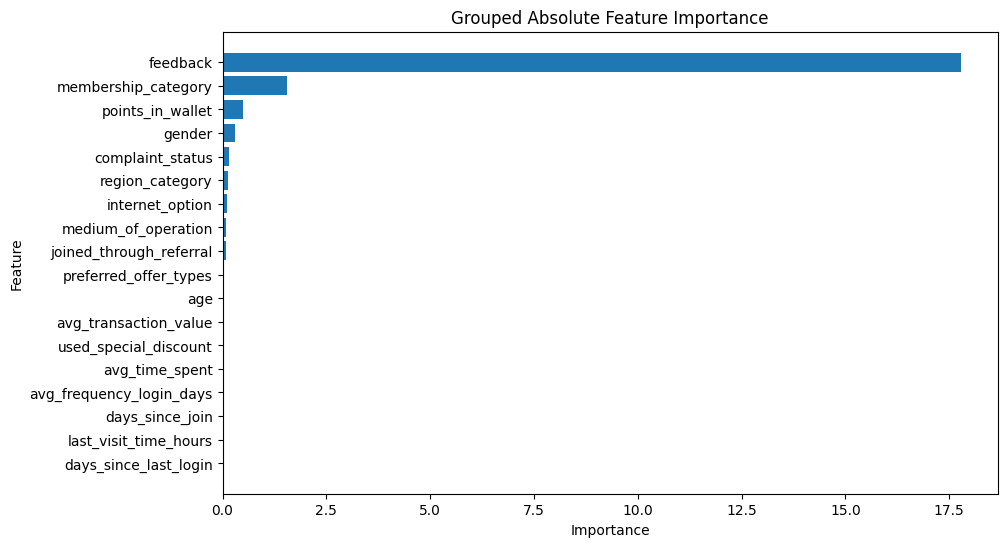

In [59]:
plt.figure(figsize=(10, 6))
plt.barh(original_feature_importances['Feature'], original_feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Grouped Absolute Feature Importance')
plt.gca().invert_yaxis()  # Umkehr der Achsen, damit die wichtigsten Features oben sind
plt.show()

Similar to the feature importnace of the one-hot encoded features, the importance of the grouped features is dominated by 'feedback' followed by 'membership_category' and 'points_in_wallet'. The same limitaions apply.

## Save predictions for error analysis in '06_01_evaluation...'

In [60]:
# create a data set with the predicted values for evaluation of test-data:
df_test_eval = df_test.copy()
y_pred = logreg.predict(X_test)
df_test_eval['y_pred'] = y_pred

In [61]:
# create a data set with the predicted values for evaluation of  train-test:
df_train_eval = df_train.copy()
y_pred_train = logreg.predict(X_train)
df_train_eval['y_pred'] = y_pred_train

In [62]:
# check if subfolder exists:
if not os.path.exists('./data/eval'):
        os.makedirs('./data/eval')

# write the dataframes with prediction outcome for next notebook 
df_train_eval.to_pickle('./data/eval/df_train_eval.pkl')
df_test_eval.to_pickle('./data/eval/df_test_eval.pkl')